In [ ]:
!pip install mediapipe

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 35.7/35.7 MB 36.2 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 294.6/294.6 kB 21.1 MB/s eta 0:00:00
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.20.3
    Uninstalling protobuf-3.20.3:
      Successfully uninstalled protobuf-3.20.3
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.15.0 requires protobuf<4.21,>=3.20.3; python_version < "3.11", but you have protobuf 4.25.3 which is incompatible.


In [ ]:
!pip install ultralytics

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 800.1/800.1 kB 8.4 MB/s eta 0:00:00
  Using cached nvidia_cuda_nvrtc_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (23.7 MB)
  Using cached nvidia_cuda_runtime_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (823 kB)
  Using cached nvidia_cuda_cupti_cu12-12.1.105-py3-none-manylinux1_x86_64.whl (14.1 MB)
  Using cached nvidia_cudnn_cu12-8.9.2.26-py3-none-manylinux1_x86_64.whl (731.7 MB)
  Using cached nvidia_cublas_cu12-12.1.3.1-py3-none-manylinux1_x86_64.whl (410.6 MB)
  Using cached nvidia_cufft_cu12-11.0.2.54-py3-none-manylinux1_x86_64.whl (121.6 MB)
  Using cached nvidia_curand_cu12-10.3.2.106-py3-none-manylinux1_x86_64.whl (56.5 MB)
  Using cached nvidia_cusolver_cu12-11.4.5.107-py3-none-manylinux1_x86_64.whl (124.2 MB)
  Using cached nvidia_cusparse_cu12-12.1.0.106-py3-none-manylinux1_x86_64.whl (196.0 MB)
  Using cached nvidia_nccl_cu12-2.20.5-py3-none-manylinux2014_x86_64.whl (176.2 MB)
  Using cached nvidia_nvtx_cu12-12.1.105-py3-none-m

In [ ]:
import cv2
import math
import numpy as np
import pandas as pd
import mediapipe as mp
from ultralytics import YOLO
import matplotlib.pyplot as plt
import gc
from scipy.signal import find_peaks
from scipy.ndimage import gaussian_filter1d
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

In [ ]:
def get_sample_frame(video_path, frame_number):

    cap = cv2.VideoCapture(video_path)
    frame_count = 0

    while True:
        ret, frame = cap.read()

        if not ret:
            break

        frame_count += 1

        if frame_count == frame_number:
            return frame

def convert_bgr_to_rgb(image):
    rgb_image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
    return rgb_image

def show_frame(video_path, frame_number):
    f = get_sample_frame(video_path, frame_number)
    f_rgb = convert_bgr_to_rgb(f)
    plt.figure(figsize = (16,8))
    plt.imshow(f_rgb)
    plt.show()

def show_image(f):
    f_rgb = convert_bgr_to_rgb(f)
    plt.figure(figsize = (16,8))
    plt.imshow(f_rgb)
    plt.show()

def get_video_attr(video_path):

    cap = cv2.VideoCapture(video_path)
    fps = int(cap.get(cv2.CAP_PROP_FPS))
    w = int(cap.get(cv2.CAP_PROP_FRAME_WIDTH))
    h = int(cap.get(cv2.CAP_PROP_FRAME_HEIGHT))
    count = int(cap.get(cv2.CAP_PROP_FRAME_COUNT))

    return {'fps':fps, 'frame_width':w, 'frame_height':h, 'frame_count':count}

In [ ]:
video_path = '/content/Bowling_run_1.mp4'

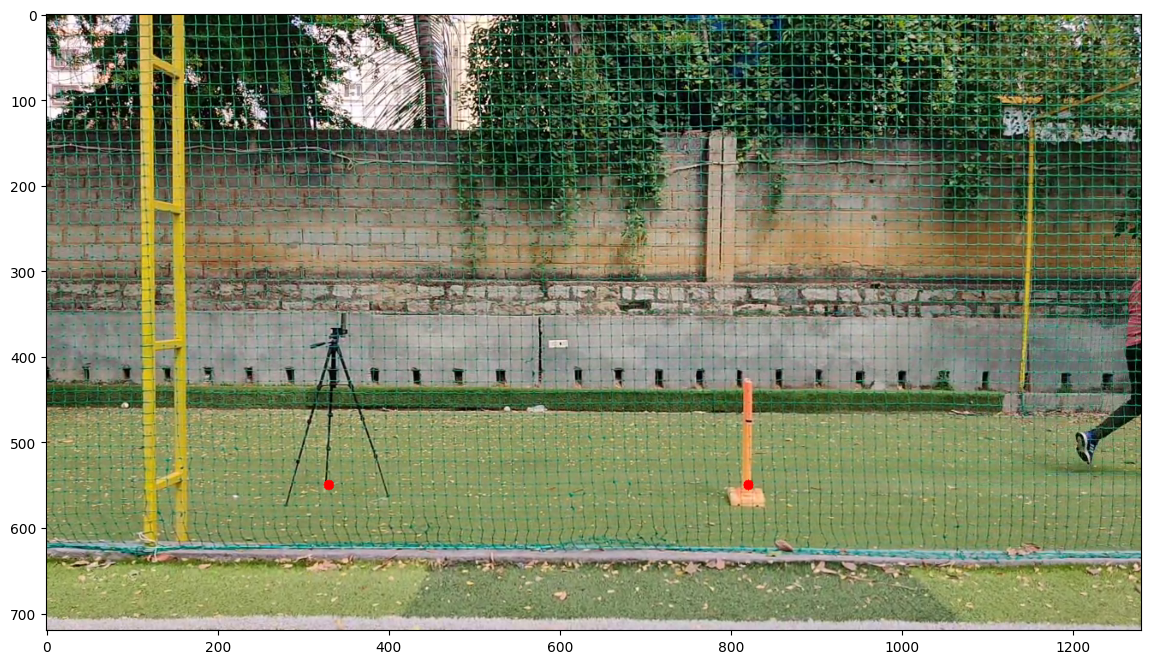

In [ ]:
f = get_sample_frame(video_path, 159)
f = convert_bgr_to_rgb(f)

f = cv2.circle(f, (330,550), 6, color = (255, 0, 0), thickness = -1)
f = cv2.circle(f, (820, 550), 6, color = (255, 0, 0), thickness = -1)
plt.figure(figsize=(16,8))
plt.imshow(f)
plt.show()

In [ ]:
tripod_x = 330
stump_x = 820
actual_dist = 2.5
x_scale = actual_dist/np.abs(stump_x-tripod_x)

In [ ]:
base_model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 23.1MB/s]



0: 384x640 7 persons, 205.9ms
Speed: 3.2ms preprocess, 205.9ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)


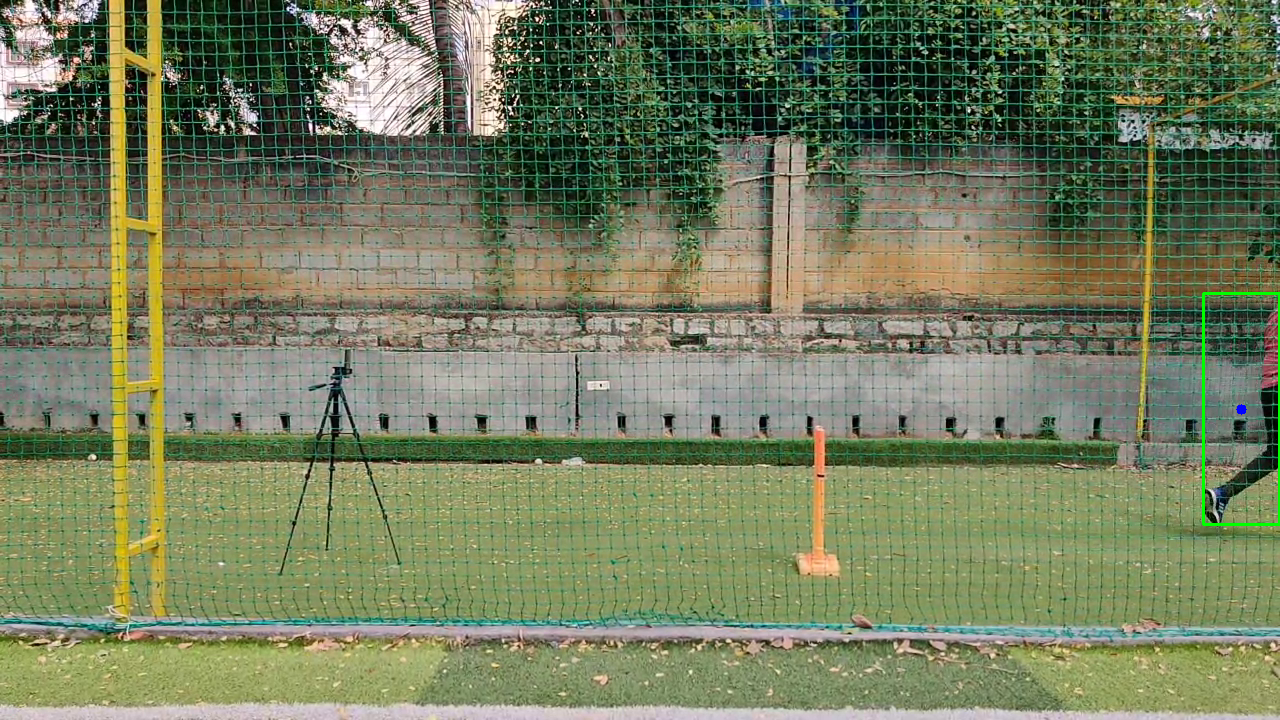

In [ ]:
from google.colab.patches import cv2_imshow
# Load the YOLOv8 model globally
base_model = YOLO('yolov8n.pt')

def get_com_and_bbox(frame):
    # Perform detection on the frame
    results = base_model(frame)

    # Extract the bounding boxes, confidences, and class labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
    confidences = results[0].boxes.conf.cpu().numpy()
    class_labels = results[0].boxes.cls.cpu().numpy()

    # Filter for 'person' class (class ID 0 for COCO dataset)
    person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

    if len(person_boxes) == 0:
        return None, None  # No person detected

    # Choose the first detected person (or implement logic to choose the appropriate one)
    person_box = person_boxes[0]

    # Extract the coordinates
    x1, y1, x2, y2 = person_box[:4]

    # Calculate the center of mass (x and y coordinates)
    x_com = (x1 + x2) / 2
    y_com = (y1 + y2) / 2

    # Bounding box as a tuple (x1, y1, x2, y2)
    bbox = (x1, y1, x2, y2)

    return (x_com, y_com), bbox

def draw_bbox_and_com(frame, com, bbox):
    if com is None or bbox is None:
        return frame

    # Draw the bounding box
    x1, y1, x2, y2 = map(int, bbox)
    cv2.rectangle(frame, (x1, y1), (x2, y2), (0, 255, 0), 2)

    # Draw the center of mass
    x_com, y_com = map(int, com)
    cv2.circle(frame, (x_com, y_com), 5, (0, 0, 255), -1)

    return frame

f = get_sample_frame(video_path, 159)
f = convert_bgr_to_rgb(f)
frame = f
com, bbox = get_com_and_bbox(frame)

# Draw bounding box and COM on the frame
output_frame = convert_bgr_to_rgb(draw_bbox_and_com(frame, com, bbox))

# Display the output frame
cv2_imshow( output_frame)
cv2.waitKey(0)
cv2.destroyAllWindows()

In [ ]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    frame_number = 0
    output_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Get COM and bounding box
        com, bbox = get_com_and_bbox(frame)

        if com is not None:
            x_com, y_com = com
            output_data.append((frame_number, x_com, y_com))

        frame_number += 1

    cap.release()
    return output_data

# Example usage:
video_path = '/content/Bowling_run_1.mp4'
output_data = process_video(video_path)

# Print the output data
for frame_num, x_com, y_com in output_data:
    print(f"Frame {frame_num}: Center of Bounding Box - (x: {x_com}, y: {y_com})")



0: 384x640 9 persons, 186.3ms
Speed: 6.6ms preprocess, 186.3ms inference, 1.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 145.2ms
Speed: 4.3ms preprocess, 145.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 153.8ms
Speed: 2.6ms preprocess, 153.8ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 167.0ms
Speed: 6.0ms preprocess, 167.0ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 175.1ms
Speed: 6.3ms preprocess, 175.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 8 persons, 151.3ms
Speed: 6.0ms preprocess, 151.3ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 9 persons, 156.4ms
Speed: 5.3ms preprocess, 156.4ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 10 persons, 150.5ms
Speed: 6.1ms preprocess, 150.5ms inference, 1.2ms postprocess p

In [ ]:
def get_com_and_bbox(frame):
    # Perform detection on the frame
    conf_threshold = .75
    results = base_model(frame,conf=conf_threshold)

    # Extract the bounding boxes, confidences, and class labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
    confidences = results[0].boxes.conf.cpu().numpy()
    class_labels = results[0].boxes.cls.cpu().numpy()

    # Filter for 'person' class (class ID 0 for COCO dataset)
    person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

    if len(person_boxes) == 0:
        return None, None  # No person detected

    # Choose the person whose bounding box base is closest to the bottom of the frame
    frame_height = frame.shape[0]

    def distance_to_bottom(box):
        x1, y1, x2, y2 = box[:4]
        return frame_height - y2  # Distance from the bottom of the bounding box to the bottom of the frame

    person_box = min(person_boxes, key=distance_to_bottom)

    # Extract the coordinates
    x1, y1, x2, y2 = person_box[:4]

    # Calculate the center of mass (x and y coordinates)
    x_com = (x1 + x2) / 2
    y_com = (y1 + y2) / 2

    # Bounding box as a tuple (x1, y1, x2, y2)
    bbox = (x1, y1, x2, y2)

    return (x_com, y_com), bbox

In [ ]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    frame_number = 0
    output_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Get COM and bounding box for the person closest to the base of the frame
        com, bbox = get_com_and_bbox(frame)

        if com is not None:
            x_com, y_com = com
            output_data.append((frame_number, x_com, y_com))
            print(bbox[2])
        if bbox != None and bbox[2]>frame.shape[1]-0.5:
              break
        frame_number += 1



    cap.release()
    return output_data

# Example usage:
video_path = '/content/Bowling_run_1.mp4'
output_data = process_video(video_path)

# Print the output data
for frame_num, x_com, y_com in output_data:
    print(f"Frame {frame_num}: Center of Bounding Box - (x: {x_com}, y: {y_com})")



0: 384x640 (no detections), 180.9ms
Speed: 4.2ms preprocess, 180.9ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 130.1ms
Speed: 2.3ms preprocess, 130.1ms inference, 0.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 134.5ms
Speed: 3.7ms preprocess, 134.5ms inference, 0.9ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 166.1ms
Speed: 2.7ms preprocess, 166.1ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 142.8ms
Speed: 4.0ms preprocess, 142.8ms inference, 1.1ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 148.1ms
Speed: 4.4ms preprocess, 148.1ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 164.9ms
Speed: 6.3ms preprocess, 164.9ms inference, 1.0ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 (no detections), 148.6ms
Speed: 3.3ms prepr

In [ ]:
output_data

[(82, 27.842313766479492, 381.0699462890625),
 (83, 48.69621276855469, 379.8963623046875),
 (84, 55.79023742675781, 380.8973388671875),
 (85, 57.56724548339844, 383.65960693359375),
 (86, 60.414798736572266, 384.2990417480469),
 (89, 133.38739013671875, 388.7391662597656),
 (92, 213.57278442382812, 387.7900695800781),
 (93, 225.15496826171875, 389.2566833496094),
 (94, 246.40423583984375, 392.712890625),
 (95, 271.8597412109375, 390.055908203125),
 (96, 283.64666748046875, 389.8025817871094),
 (97, 303.9608459472656, 389.2964782714844),
 (98, 312.18646240234375, 389.3999328613281),
 (99, 334.197509765625, 388.3170166015625),
 (100, 342.50091552734375, 387.0537109375),
 (101, 389.6171875, 388.35369873046875),
 (102, 404.529296875, 389.07464599609375),
 (103, 426.54376220703125, 391.47418212890625),
 (104, 451.09381103515625, 390.2584533691406),
 (105, 468.7430419921875, 389.5960388183594),
 (106, 471.6573791503906, 390.84619140625),
 (107, 490.06768798828125, 390.527587890625),
 (108, 5

In [ ]:
fps = get_video_attr(video_path)['fps']
fps

60

In [ ]:
output_data[0][1]

27.842313766479492

In [ ]:
count = 1
frame = []
speed = []
prev_x = output_data[0][1]
curr_x = output_data[0][1]
prev_frame = output_data[0][0]
curr_frame = output_data[0][0]

for frame_num,x_com,y_com in output_data:
  if count%10 == 0:
    curr_x = x_com
    dist = np.abs(curr_x - prev_x)*x_scale
    prev_x = curr_x
    curr_frame = frame_num
    time = (curr_frame - prev_frame)/fps
    prev_frame = curr_frame
    speed.append((dist/time)*3.6)
    frame.append(frame_num)
  count+=1


In [ ]:
speed

[20.68593576452234,
 21.69734335140306,
 23.645972676179845,
 20.73966288663903,
 14.197102698501276,
 17.454701450892856]

In [ ]:
frame

[95, 105, 115, 125, 135, 145]

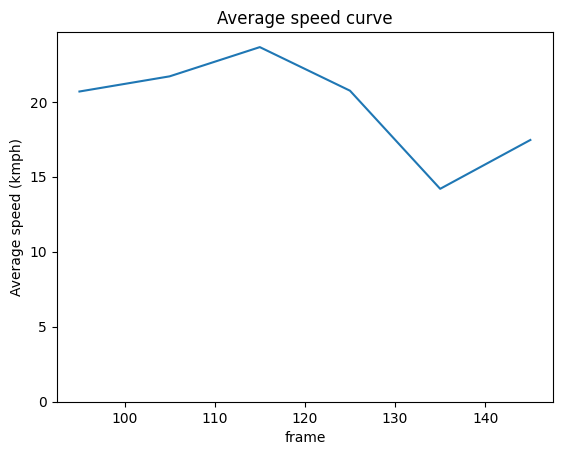

In [ ]:
plt.ylim(0,max(speed)+1)
plt.xlabel('frame')
plt.ylabel('Average speed (kmph)')
plt.title('Average speed curve')
plt.plot(frame,speed)
plt.show()

In [ ]:
f.shape

(720, 1280, 3)

In [ ]:
video_path = '/content/Bowling_run_2.mp4'

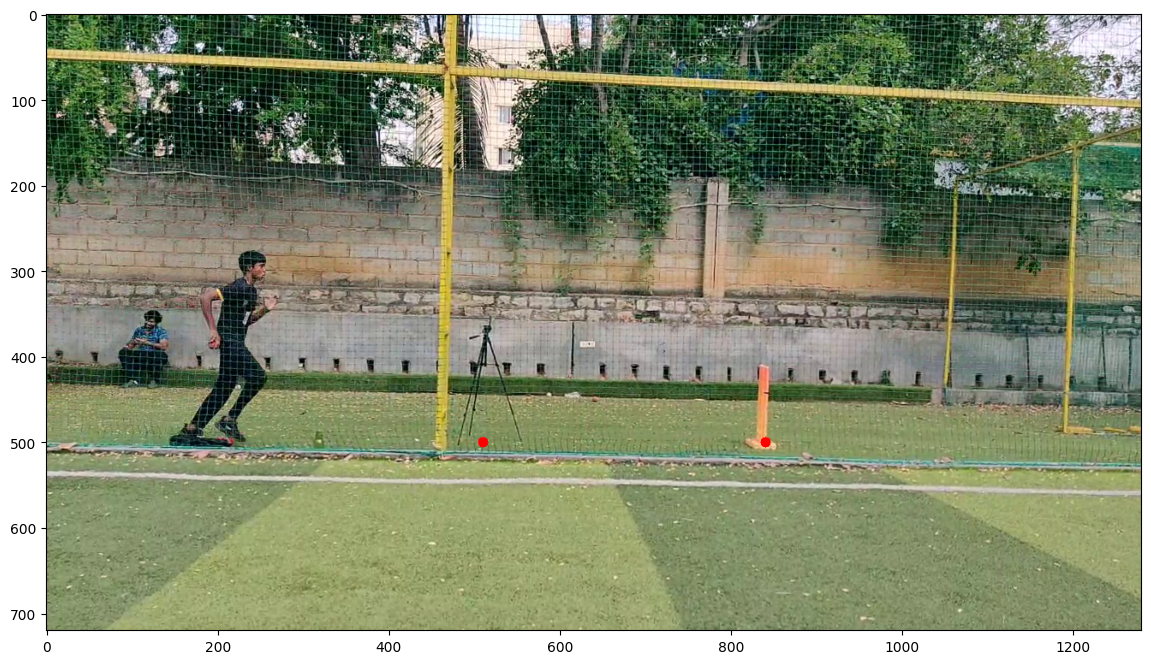

In [ ]:
f = get_sample_frame(video_path, 160)
f = convert_bgr_to_rgb(f)

f = cv2.circle(f, (510,500), 6, color = (255, 0, 0), thickness = -1)
f = cv2.circle(f, (840, 500), 6, color = (255, 0, 0), thickness = -1)
plt.figure(figsize=(16,8))
plt.imshow(f)
plt.show()

In [ ]:
tripod_x = 510
stump_x = 840
actual_dist = 2
x_scale = actual_dist/np.abs(stump_x-tripod_x)

In [ ]:
def get_com_and_bbox(frame):
    # Perform detection on the frame
    conf_threshold = .75
    results = base_model(frame,conf=conf_threshold)

    # Extract the bounding boxes, confidences, and class labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
    confidences = results[0].boxes.conf.cpu().numpy()
    class_labels = results[0].boxes.cls.cpu().numpy()

    # Filter for 'person' class (class ID 0 for COCO dataset)
    person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

    if len(person_boxes) == 0:
        return None, None  # No person detected

    # Choose the person whose bounding box base is closest to the bottom of the frame
    frame_height = frame.shape[0]

    def distance_to_bottom(box):
        x1, y1, x2, y2 = box[:4]
        return frame_height - y2  # Distance from the bottom of the bounding box to the bottom of the frame

    person_box = min(person_boxes, key=distance_to_bottom)

    # Extract the coordinates
    x1, y1, x2, y2 = person_box[:4]

    # Calculate the center of mass (x and y coordinates)
    x_com = (x1 + x2) / 2
    y_com = (y1 + y2) / 2

    # Bounding box as a tuple (x1, y1, x2, y2)
    bbox = (x1, y1, x2, y2)

    return (x_com, y_com), bbox

In [ ]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    frame_number = 0
    output_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Get COM and bounding box for the person closest to the base of the frame
        com, bbox = get_com_and_bbox(frame)

        if com is not None  and com[0]<1150 and frame_number>150:
            x_com, y_com = com
            output_data.append((frame_number, x_com, y_com))
            print(bbox[2])
        frame_number += 1

    cap.release()
    return output_data


output_data = process_video(video_path)

# Print the output data
for frame_num, x_com, y_com in output_data:
    print(f"Frame {frame_num}: Center of Bounding Box - (x: {x_com}, y: {y_com})")

NameError: name 'get_com_and_bbox' is not defined

In [ ]:
fps = get_video_attr(video_path)['fps']
count = 1
frame = []
speed = []
prev_x = output_data[0][1]
curr_x = output_data[0][1]
prev_frame = output_data[0][0]
curr_frame = output_data[0][0]

for frame_num,x_com,y_com in output_data:
  if count%10 == 0:
    curr_x = x_com
    dist = (np.abs(curr_x - prev_x))*x_scale
    prev_x = curr_x
    curr_frame = frame_num
    time = (curr_frame - prev_frame)/fps
    prev_frame = curr_frame
    speed.append((dist/time)*3.6)
    frame.append(frame_num)
  count+=1

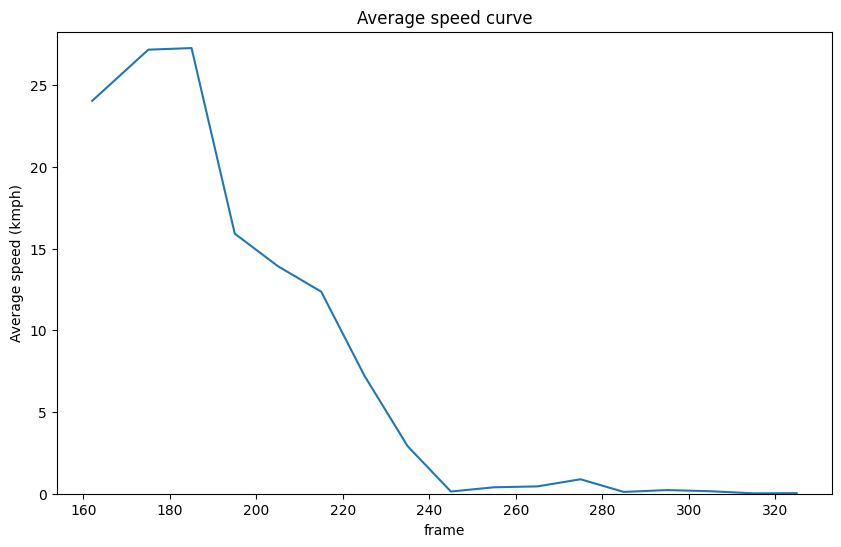

In [ ]:
plt.figure(figsize=(10,6))
plt.ylim(0,max(speed)+1)
plt.xlabel('frame')
plt.ylabel('Average speed (kmph)')
plt.title('Average speed curve')
plt.plot(frame,speed)
plt.show()

In [ ]:
video_path = '/content/Bowling_run_1_bowl.mp4'

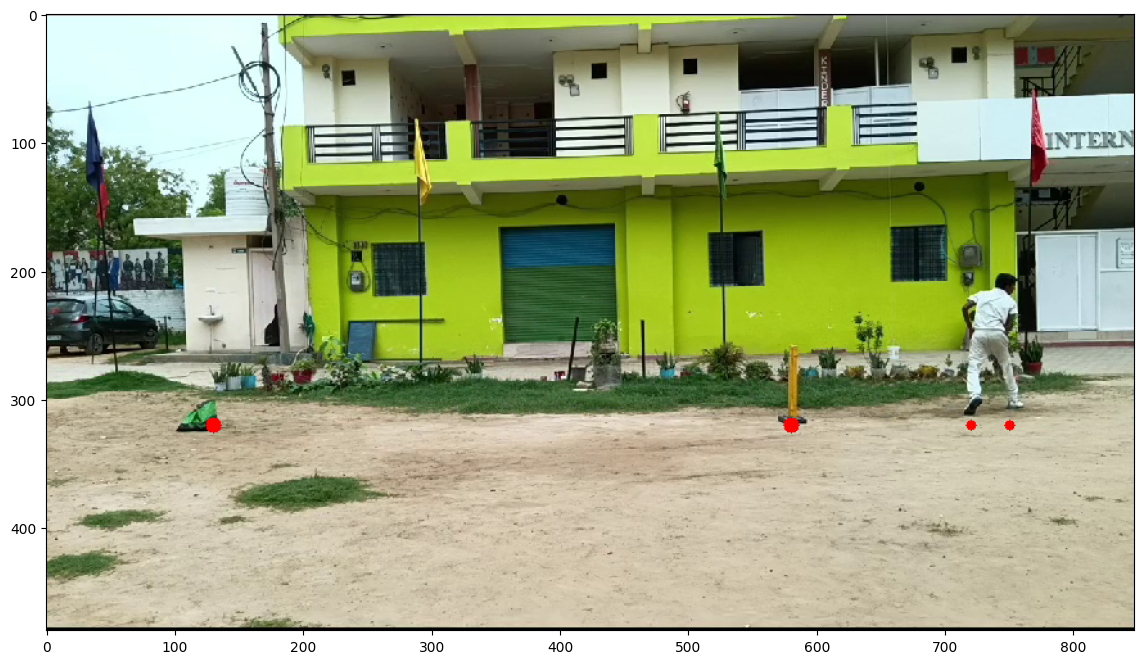

0.6666666666666667


In [ ]:
f = get_sample_frame(video_path, 133)
f = convert_bgr_to_rgb(f)

f = cv2.circle(f, (130,320), 6, color = (255, 0, 0), thickness = -1)
f = cv2.circle(f, (580, 320), 6, color = (255, 0, 0), thickness = -1)
right_f = 750
left_f = 720
f = cv2.circle(f, (right_f,320), 4, color = (255, 0, 0), thickness = -1)
f = cv2.circle(f, (left_f, 320),4 , color = (255, 0, 0), thickness = -1)
plt.figure(figsize=(16,8))
plt.imshow(f)
plt.show()
print(np.abs(left_f-right_f)*x_scale)

In [ ]:
tripod_x = 130
stump_x = 580
actual_dist = 10
x_scale = actual_dist/np.abs(stump_x-tripod_x)

In [ ]:
def get_com_and_bbox(frame):
    # Perform detection on the frame
    conf_threshold = .6
    results = base_model(frame,conf=conf_threshold)

    # Extract the bounding boxes, confidences, and class labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
    confidences = results[0].boxes.conf.cpu().numpy()
    class_labels = results[0].boxes.cls.cpu().numpy()

    # Filter for 'person' class (class ID 0 for COCO dataset)
    person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

    if len(person_boxes) == 0:
        return None, None  # No person detected

    # Choose the person whose bounding box base is closest to the bottom of the frame
    frame_height = frame.shape[0]

    def distance_to_bottom(box):
        x1, y1, x2, y2 = box[:4]
        return frame_height - y2  # Distance from the bottom of the bounding box to the bottom of the frame

    person_box = min(person_boxes, key=distance_to_bottom)

    # Extract the coordinates
    x1, y1, x2, y2 = person_box[:4]

    # Calculate the center of mass (x and y coordinates)
    x_com = (x1 + x2) / 2
    y_com = (y1 + y2) / 2

    # Bounding box as a tuple (x1, y1, x2, y2)
    bbox = (x1, y1, x2, y2)

    return (x_com, y_com), bbox

In [ ]:
def process_video(video_path):
    # Open the video file
    cap = cv2.VideoCapture(video_path)

    frame_number = 0
    output_data = []

    while cap.isOpened():
        ret, frame = cap.read()
        if not ret:
            break

        # Get COM and bounding box for the person closest to the base of the frame
        com, bbox = get_com_and_bbox(frame)

        if com is not None:
            x_com, y_com = com
            output_data.append((frame_number, x_com, y_com))
            print(bbox[2])
        frame_number += 1

    cap.release()
    return output_data


output_data = process_video(video_path)

# Print the output data
for frame_num, x_com, y_com in output_data:
    print(f"Frame {frame_num}: Center of Bounding Box - (x: {x_com}, y: {y_com})")


0: 384x640 1 person, 1 car, 452.0ms
Speed: 18.8ms preprocess, 452.0ms inference, 42.9ms postprocess per image at shape (1, 3, 384, 640)
180.064

0: 384x640 1 person, 1 car, 224.3ms
Speed: 4.7ms preprocess, 224.3ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)
181.83514

0: 384x640 1 person, 1 car, 237.3ms
Speed: 7.5ms preprocess, 237.3ms inference, 2.0ms postprocess per image at shape (1, 3, 384, 640)
186.79053

0: 384x640 1 person, 1 car, 270.0ms
Speed: 3.7ms preprocess, 270.0ms inference, 5.0ms postprocess per image at shape (1, 3, 384, 640)
191.74373

0: 384x640 1 person, 1 car, 243.8ms
Speed: 5.7ms preprocess, 243.8ms inference, 1.8ms postprocess per image at shape (1, 3, 384, 640)
183.543

0: 384x640 1 person, 1 car, 255.4ms
Speed: 6.6ms preprocess, 255.4ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)
182.35294

0: 384x640 1 person, 1 car, 260.7ms
Speed: 4.1ms preprocess, 260.7ms inference, 2.1ms postprocess per image at shape (1, 3, 384, 64

In [ ]:
fps = get_video_attr(video_path)['fps']
count = 1
frame = []
speed = []
prev_x = output_data[0][1]
curr_x = output_data[0][1]
prev_frame = output_data[0][0]
curr_frame = output_data[0][0]
frame1 = [15,23,38,55,66,76,84,93,102,114,133]

for frame_num,x_com,y_com in output_data:
  if frame_num in frame1:
    curr_x = x_com
    dist = (np.abs(curr_x - prev_x))*x_scale
    prev_x = curr_x
    curr_frame = frame_num
    time = (curr_frame - prev_frame)/fps
    prev_frame = curr_frame
    speed.append((dist/time)*3.6)
    frame.append(frame_num)
  count+=1

In [ ]:
fps = get_video_attr(video_path)['fps']
count = 1
frame = []
speed = []
prev_x = output_data[0][1]
curr_x = output_data[0][1]
prev_frame = output_data[0][0]
curr_frame = output_data[0][0]

for frame_num,x_com,y_com in output_data:
  if count%15 == 0:
    curr_x = x_com
    dist = (np.abs(curr_x - prev_x))*x_scale
    prev_x = curr_x
    curr_frame = frame_num
    time = (curr_frame - prev_frame)/fps
    prev_frame = curr_frame
    speed.append((dist/time)*3.6)
    frame.append(frame_num)
  count+=1

In [ ]:
frame

[15, 23, 38, 55, 66, 76, 84, 93, 102, 114, 133]

In [ ]:
speed

[3.214371988932292,
 4.4829594421386725,
 7.6024321289062495,
 9.1688427734375,
 10.722874866832388,
 16.119751953125,
 15.643043212890625,
 19.380596788194445,
 15.692096354166665,
 12.048865152994793,
 6.5853446237664475]

In [ ]:
dist=[0,0.88,1.44,1.44,1,1.1,1.22,1.33,1.11,1.33,0.66]
len(dist)

11

In [ ]:
step_dist = [0]
dist1=dist[0]
for i in range(1,len(dist)):
  dist1+=dist[i]
  step_dist.append(dist1)

In [ ]:
step_dist

[0,
 0.88,
 2.32,
 3.76,
 4.76,
 5.859999999999999,
 7.079999999999999,
 8.41,
 9.52,
 10.85,
 11.51]

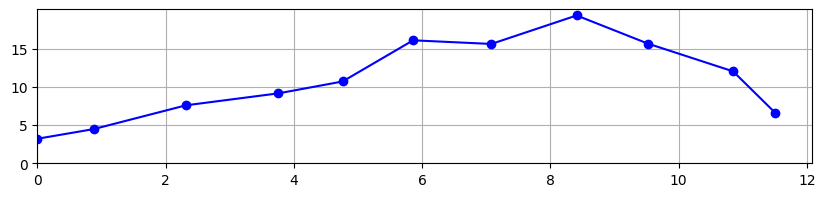

In [ ]:
plt.figure(figsize=(10, 2))
plt.plot(step_dist, speed, marker='o', linestyle='-', color='b')
plt.yticks(range(0, int(max(speed)+1), 5))
plt.xlim(left=min(step_dist))
plt.grid(True)
plt.show()

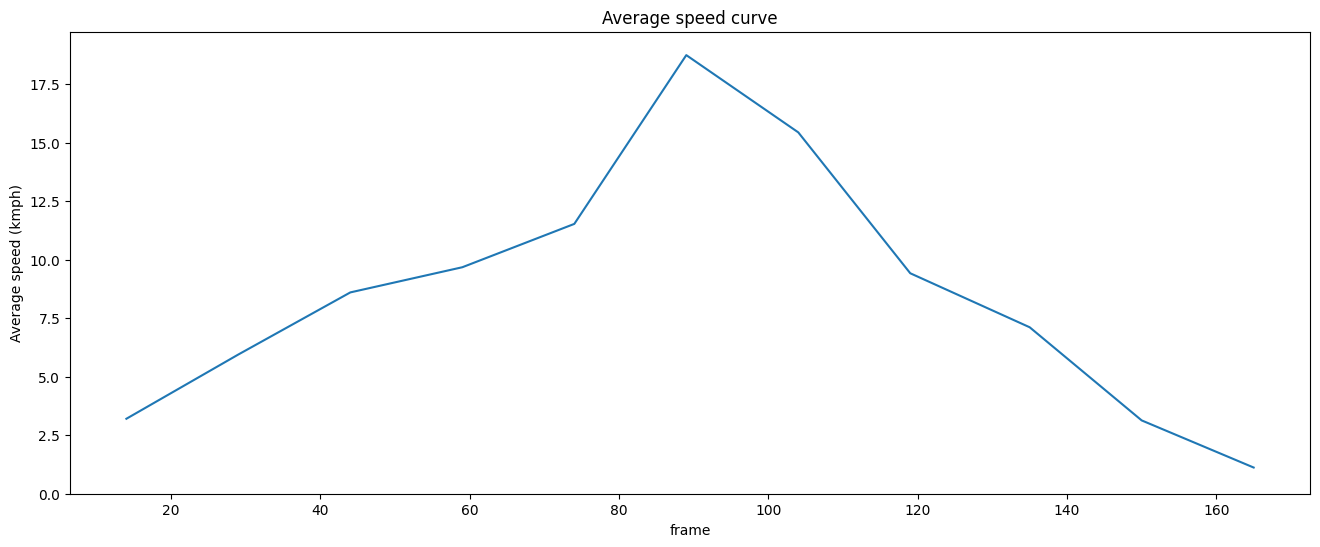

In [ ]:
plt.figure(figsize=(16,6))
plt.ylim(0,max(speed)+1)
plt.xlabel('frame')
plt.ylabel('Average speed (kmph)')
plt.title('Average speed curve')
plt.plot(frame,speed)
plt.show()

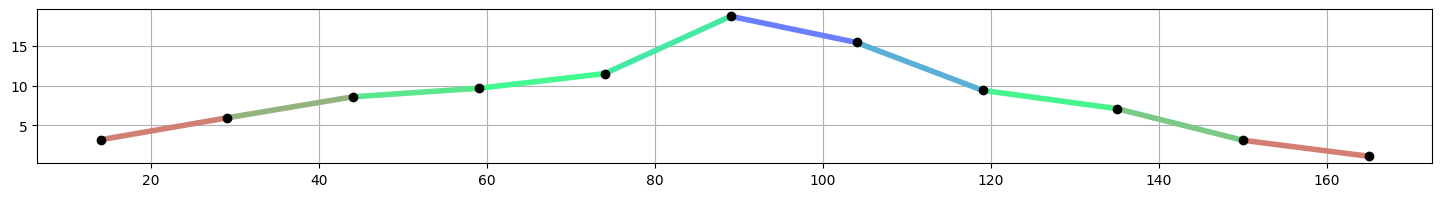

In [ ]:
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.collections import LineCollection
from matplotlib.colors import LinearSegmentedColormap

# Generate example data
x = [14, 29, 44, 59, 74, 89, 104, 119, 135, 150, 165]
y = [3.2032650320870535,
 5.949130045572916,
 8.60182763671875,
 9.676833658854168,
 11.5285478515625,
 18.739531901041666,
 15.439233723958335,
 9.4195341796875,
 7.111336669921875,
 3.132188802083333,
 1.1190299479166665]


# Define a custom colormap that transitions from red to green to blue
colors = [(225/225,77/225,92/225), (35/148,148/148,84/148), (103/247,123/247,247/247)]  # Red to Green to Blue
n_bins = 1000  # Number of bins for the colormap
cmap_name = 'custom_cmap'

# Create the colormap
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)

# Normalize y values for color mapping
norm = plt.Normalize(min(y), max(y))

# Create line segments
points = np.array([x, y]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

# Create a LineCollection from the segments
lc = LineCollection(segments, cmap=cm, norm=norm)
lc.set_array(y)  # Set the y values to map colors
lc.set_linewidth(4)  # Set the line width

# Create the plot
fig, ax = plt.subplots(figsize=(18,2))
ax.add_collection(lc)
ax.autoscale()
plt.yticks(range(0, int(max(y)+4), 5))

# Enable grid lines
ax.grid(True)
ax.scatter(x, y, color='black', zorder=5)

# Display the plot without colorbar
plt.show()



0: 384x640 1 person, 1 car, 339.3ms
Speed: 4.7ms preprocess, 339.3ms inference, 3.3ms postprocess per image at shape (1, 3, 384, 640)


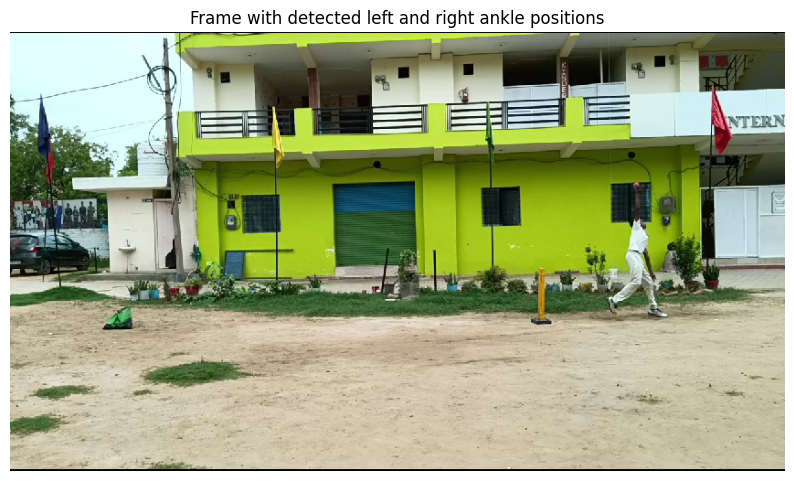

In [ ]:
frame = get_sample_frame(video_path, 116)

mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

model = YOLO('yolov8n.pt')

# Use YOLOv8 to detect people
conf_threshold = .6
results = model(frame,conf=conf_threshold)

# Extract the bounding boxes, confidences, and class labels
boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
confidences = results[0].boxes.conf.cpu().numpy()
class_labels = results[0].boxes.cls.cpu().numpy()

# Filter for 'person' class (class ID 0 for COCO dataset)
person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

# Choose the person whose bounding box base is closest to the bottom of the frame
frame_height = frame.shape[0]

def distance_to_bottom(box):
  x1, y1, x2, y2 = box[:4]
  return frame_height - y2  # Distance from the bottom of the bounding box to the bottom of the frame

person_box = min(person_boxes, key=distance_to_bottom)

# Extract the coordinates
x1, y1, x2, y2 = person_box[:4]

# Crop the detected person
roi = frame[int(y1):int(y2), int(x1):int(x2)]

# Convert the cropped image to RGB
roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

# Run MediaPipe pose estimation
result = pose.process(roi_rgb)

left_ankle = None
right_ankle = None

if result.pose_landmarks:
    for id, lm in enumerate(result.pose_landmarks.landmark):
        h, w, c = roi.shape
        cx, cy = int(lm.x * w), int(lm.y * h)
        if id == mp_pose.PoseLandmark.LEFT_HEEL.value:
            left_ankle = (cx + int(x1), cy + int(y1))  # Adjust coordinates
        elif id == mp_pose.PoseLandmark.RIGHT_HEEL.value:
            right_ankle = (cx + int(x1), cy + int(y1))  # Adjust coordinates

    # Draw the landmarks on the original frame
    if left_ankle:
        cv2.circle(frame, left_ankle, 5, (0, 255, 0), -1)
    if right_ankle:
        cv2.circle(frame, right_ankle, 5, (0, 0, 255), -1)

# Visualize the frame with detected points
plt.figure(figsize=(10, 10))
plt.imshow(cv2.cvtColor(frame, cv2.COLOR_BGR2RGB))
plt.title("Frame with detected left and right ankle positions")
plt.axis('off')
plt.show()

In [ ]:
model = YOLO('yolov8n.pt')

100%|██████████| 6.25M/6.25M [00:00<00:00, 61.2MB/s]


In [ ]:
mp_pose = mp.solutions.pose
pose = mp_pose.Pose()

# Load the video
video_path = '/content/Bowling_run_1_bowl.mp4'
cap = cv2.VideoCapture(video_path)

frame_index = 0
detected_frames = []
x_diff_list = []
output_data = [] # stores (frame_num,x_com,y_com)

# Iterate through each frame of the video
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        break

    # Use YOLOv8 to detect people
    conf_threshold = 0.6
    results = model(frame, conf=conf_threshold)

    # Extract the bounding boxes, confidences, and class labels
    boxes = results[0].boxes.xyxy.cpu().numpy()  # xyxy format: [x1, y1, x2, y2]
    confidences = results[0].boxes.conf.cpu().numpy()
    class_labels = results[0].boxes.cls.cpu().numpy()

    # Filter for 'person' class (class ID 0 for COCO dataset)
    person_boxes = [boxes[i] for i in range(len(class_labels)) if class_labels[i] == 0]

    # Choose the person whose bounding box base is closest to the bottom of the frame
    frame_height = frame.shape[0]

    def distance_to_bottom(box):
        x1, y1, x2, y2 = box[:4]
        return frame_height - y2  # Distance from the bottom of the bounding box to the bottom of the frame

    if not person_boxes:
        frame_index += 1
        continue

    person_box = min(person_boxes, key=distance_to_bottom)

    # Extract the coordinates
    x1, y1, x2, y2 = person_box[:4]

    # Crop the detected person
    roi = frame[int(y1):int(y2), int(x1):int(x2)]

    # Convert the cropped image to RGB
    roi_rgb = cv2.cvtColor(roi, cv2.COLOR_BGR2RGB)

    # Run MediaPipe pose estimation
    result = pose.process(roi_rgb)

    left_ankle = None
    right_ankle = None

    if result.pose_landmarks:
        for id, lm in enumerate(result.pose_landmarks.landmark):
            h, w, c = roi.shape
            cx, cy = int(lm.x * w), int(lm.y * h)
            if id == mp_pose.PoseLandmark.LEFT_ANKLE.value:  #or else LEFT_HEEL
                left_ankle = (cx + int(x1), cy + int(y1))  # Adjust coordinates
            elif id == mp_pose.PoseLandmark.RIGHT_ANKLE.value:  #or else RIGHT_HEEL
                right_ankle = (cx + int(x1), cy + int(y1))  # Adjust coordinates

        if left_ankle and right_ankle:
            detected_frames.append(frame_index)
            x_diff = abs(left_ankle[0] - right_ankle[0])
            x_diff_list.append(x_diff)
            x_com = (x1+x2)/2
            player_frame_height = np.abs(y1-y2)
            output_data.append((frame_index,x_com,player_frame_height))


    frame_index += 1

cap.release()

# Print results
print("Frames with detected ankles:", detected_frames)
print("Absolute differences in x-coordinates:", x_diff_list)


0: 384x640 1 person, 1 car, 331.4ms
Speed: 21.2ms preprocess, 331.4ms inference, 33.7ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 156.1ms
Speed: 2.4ms preprocess, 156.1ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)


/usr/local/lib/python3.10/dist-packages/google/protobuf/symbol_database.py:55: UserWarning: SymbolDatabase.GetPrototype() is deprecated. Please use message_factory.GetMessageClass() instead. SymbolDatabase.GetPrototype() will be removed soon.
  warnings.warn('SymbolDatabase.GetPrototype() is deprecated. Please '



0: 384x640 1 person, 1 car, 154.5ms
Speed: 3.5ms preprocess, 154.5ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 165.9ms
Speed: 3.6ms preprocess, 165.9ms inference, 3.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 152.6ms
Speed: 3.7ms preprocess, 152.6ms inference, 1.2ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 155.2ms
Speed: 3.1ms preprocess, 155.2ms inference, 1.3ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 142.7ms
Speed: 4.9ms preprocess, 142.7ms inference, 1.4ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 161.4ms
Speed: 4.8ms preprocess, 161.4ms inference, 1.6ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 178.7ms
Speed: 3.2ms preprocess, 178.7ms inference, 2.8ms postprocess per image at shape (1, 3, 384, 640)

0: 384x640 1 person, 1 car, 241.0ms
Speed: 4.9ms prepr

[  1   2   3   4   5   6   7   8   9  10  11  12  13  14  15  16  17  18  19  20  21  22  23  24  25  26  27  28  29  30  31  32  33  34  35  36  37  38  39  40  41  42  43  44  45  46  47  48  49  50  51  52  53  54  55  56  57  58  59  60  61  62  63  64  65  66  67  68  69  70  71  72  73  74  75  76  77  78  79
  80  81  82  83  84  85  86  87  88  89  90  91  92  93  94  95  96  97  98  99 100 101 102 103 104 105 106 107 108 109 110 111 112 113 114 115 116 117 118 119 120 121 122 123 124 125 126 127 128 129 130 131 132 133 134 135 136 137 138 139 140 141 142 143 144 145 146 147 148 149 150 151 152 153 154 155 156 157 158
 159 160 161 162 163 164 165 166 167 168 169 170 171 172]
[ 9  7  2  3  2  0  1  1  2  2  2  2  5  9 15 21 29 34 39 39 41 24 29 33 33 24 11  5  3  9 16 28 36 43 50 54 55 55 54 52 52 41 32 23 11  0  8 19 30 35 46 49 55 54 54 48 44 37 19  8  3  4 16 31 39 45 44 39 34 13  0  0  9 20 26 20 10  5 12  4  1 26 38 47 48  9  4 10  2 15 33 47 40 32  5  0  1  2 15  3 37 37 2

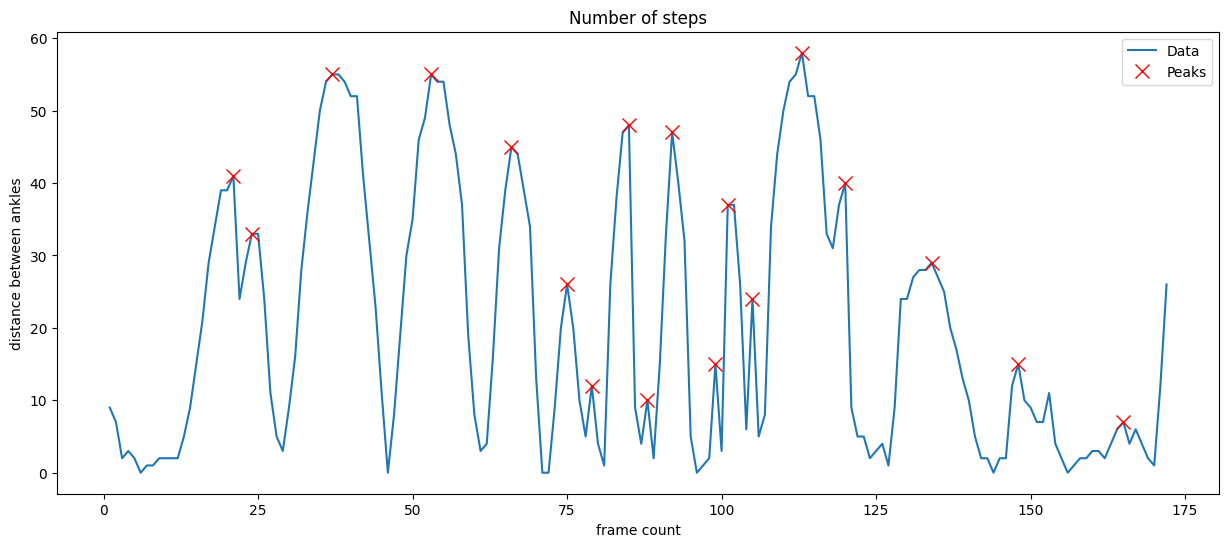

Number of steps:18


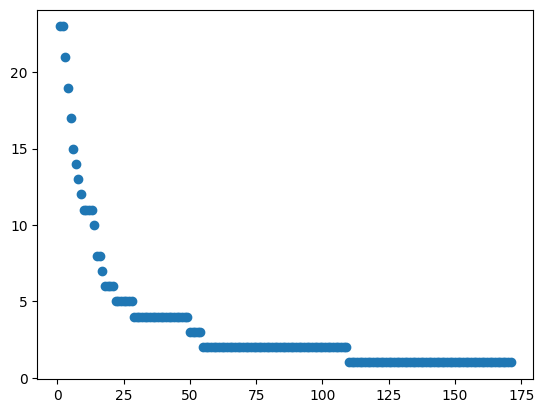

In [ ]:
#To get the peaks from the graph

distances = np.array(x_diff_list)
x = np.arange(1,distances.shape[0] +1)
y = distances

x = np.array(x)
y = np.array(y)
print(x)
print(y)

# Finding peaks
peaks, properties = find_peaks(y, height=0,distance=1, prominence=5)  # Adjust the height,distance,prominence parameter as needed

print("Peaks found at indices:", peaks)
print("Peak heights:", properties['peak_heights'])

if peaks.size > 0:
    print("x[peaks]:", x[peaks])
    print("y[peaks]:", y[peaks])
    plt.figure(figsize=(15, 6))

    plt.plot(x, y, label='Data')

    plt.plot(x[peaks], y[peaks], "x", label='Peaks', markersize=10, color='red')

    plt.xlabel('frame count')
    plt.ylabel('distance between ankles')
    plt.title('Number of steps')
    plt.legend()

    plt.show()
else:
    print("No peaks found in the data.")
step_count = peaks.shape[0]
print(f'Number of steps:{step_count}')
frame_distance=[]
Num_steps=[]
for i in range(1,int(x.shape[0])):
  frame_distance.append(i)
  peaks, properties = find_peaks(y, height=0,distance=i, prominence=0)
  Num_steps.append(peaks.shape[0])
plt.scatter(frame_distance,Num_steps)

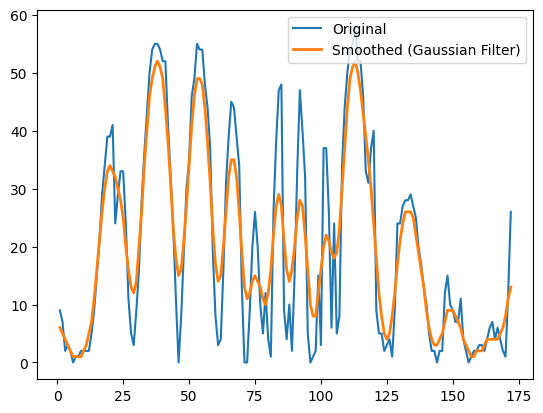

In [ ]:
from scipy.ndimage import gaussian_filter1d

# Generate some noisy data
distances = np.array(distances)
x_s = np.arange(1,distances.shape[0] +1)
y_s = distances

# Apply Gaussian filter
sigma = 2
y_smoothed = gaussian_filter1d(y_s, sigma)

# Plot the original and smoothed data
plt.plot(x_s, y_s, label='Original')
plt.plot(x_s, y_smoothed, label='Smoothed (Gaussian Filter)', linewidth=2)
plt.legend()
plt.show()

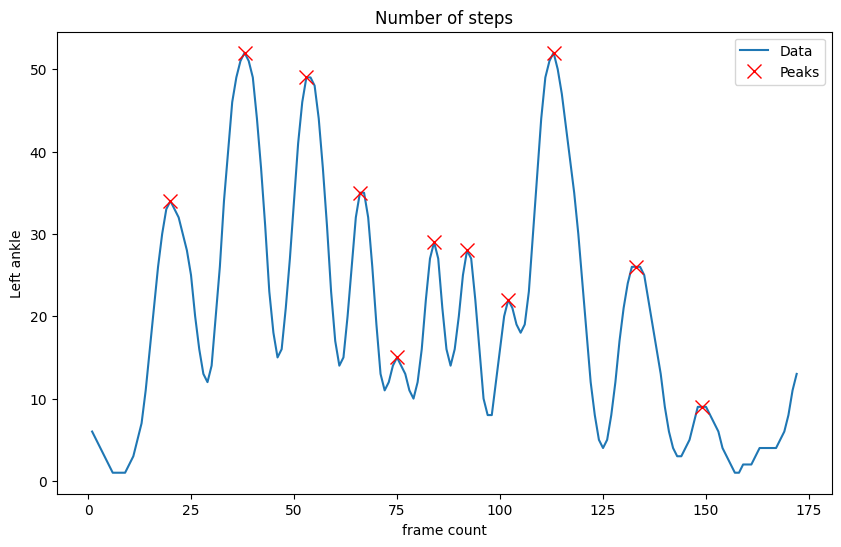

Number of steps left foot:11
[ 20  38  53  66  75  84  92 102 113 133 149]


In [ ]:
x_l = np.arange(1,distances.shape[0] +1)
y_l = y_smoothed


# Finding peaks
peaks_l, properties = find_peaks(y_l, height=0,distance=1, prominence=0)  # Adjust the height,distance,prominence parameter as needed

if peaks_l.size > 0:
    plt.figure(figsize=(10, 6))

    plt.plot(x_l, y_l, label='Data')

    plt.plot(x_l[peaks_l], y_l[peaks_l], "x", label='Peaks', markersize=10, color='red')

    plt.xlabel('frame count')
    plt.ylabel('Left ankle')
    plt.title('Number of steps')
    plt.legend()

    plt.show()
else:
    print("No peaks found in the data.")

step_count_l = peaks_l.shape[0]
print(f'Number of steps left foot:{step_count_l}')
print(x_l[peaks_l])

In [ ]:
step_dist = y_s[peaks_l]*x_scale

In [ ]:
step_dist

array([    0.86667,      1.2222,      1.2222,           1,     0.57778,      1.0444,      1.0444,     0.82222,      1.2889,     0.62222,     0.22222])

In [ ]:
frame1=np.append(x_l[peaks_l][0]-10,x_l[peaks_l])
frame1

array([ 10,  20,  38,  53,  66,  75,  84,  92, 102, 113, 133, 149])

In [ ]:
max_tuple = max(output_data, key=lambda x: x[2])

# Extract the a value corresponding to the maximum c value
release_frame = max_tuple[0]
release_frame

116

In [ ]:
fps = get_video_attr(video_path)['fps']
frame = []
speed = []
prev_x = output_data[0][1]
curr_x = output_data[0][1]
prev_frame = output_data[0][0]
curr_frame = output_data[0][0]

for frame_num,x_com,y_com in output_data:
  if frame_num in frame1:
    curr_x = x_com
    dist = (np.abs(curr_x - prev_x))*x_scale
    prev_x = curr_x
    curr_frame = frame_num
    time = (curr_frame - prev_frame)/fps
    prev_frame = curr_frame
    speed.append((dist/time)*3.6)
    frame.append(frame_num)


In [ ]:
frame

[10, 20, 38, 53, 66, 75, 84, 92, 102, 113, 133, 149]

In [ ]:
f_b_i = 0
f_b = 0
f_a_i = 0
f_a = 0
for i in range(1,len(frame)):
  if frame[i] > release_frame and frame[i-1]<=release_frame:
    f_b_i = i-1
    f_b = frame[i-1]
    f_a_i = i
    f_a = frame[i]
#print(f_b_i,f_b,f_a_i,f_a)
release_frame_ratio = (release_frame-f_b)/(f_a-f_b)

In [ ]:
step_dist=np.append(0,step_dist)
step_dist

array([          0,     0.86667,      1.2222,      1.2222,           1,     0.57778,      1.0444,      1.0444,     0.82222,      1.2889,     0.62222,     0.22222])

In [ ]:
step_dist1 = [0]
dist1=step_dist[0]
for i in range(1,len(step_dist)):
  dist1+=step_dist[i]
  step_dist1.append(dist1)
step_dist1

[0,
 0.8666666666666667,
 2.088888888888889,
 3.3111111111111113,
 4.311111111111112,
 4.888888888888889,
 5.933333333333334,
 6.977777777777778,
 7.8,
 9.088888888888889,
 9.71111111111111,
 9.933333333333332]

In [ ]:
speed

[3.1516259765625,
 4.09855810546875,
 6.978549804687501,
 9.79156396484375,
 9.7652685546875,
 13.616563585069445,
 18.19919921875,
 19.47577270507813,
 15.984805664062499,
 11.653358043323864,
 7.076049560546875,
 3.288643188476563]

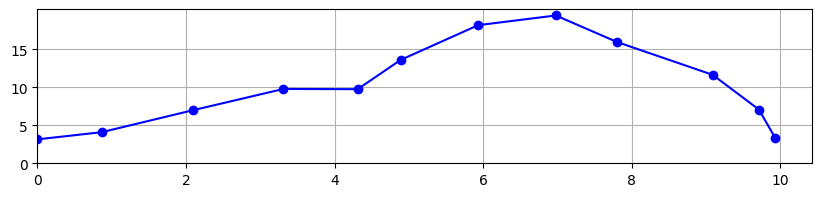

In [ ]:
plt.figure(figsize=(10, 2))
plt.plot(step_dist1, speed, marker='o', linestyle='-', color='b')
plt.yticks(range(0, int(max(speed)+1), 5))
plt.xlim(left=min(step_dist1))
plt.grid(True)
plt.show()

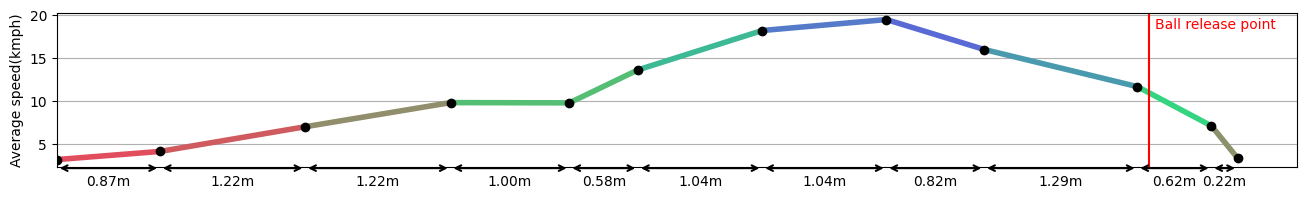

In [ ]:
colors = [(225/254.986,77/254.986,92/254.986), (35/173.74,148/173.74,84/173.74), (103/294.53,123/294.53,247/294.53)]  # Red to Green to Blue
n_bins = 100
cmap_name = 'custom_cmap'
cm = LinearSegmentedColormap.from_list(cmap_name, colors, N=n_bins)
norm = plt.Normalize(min(speed), max(speed))

points = np.array([step_dist1, speed]).T.reshape(-1, 1, 2)
segments = np.concatenate([points[:-1], points[1:]], axis=1)

lc = LineCollection(segments, cmap=cm, norm=norm)
lc.set_array(speed)
lc.set_linewidth(4)

fig, ax = plt.subplots(figsize=(16,2))
ax.add_collection(lc)
ax.autoscale()
ax.set_xticks([])
plt.yticks(range(0, int(max(speed)+4), 5))
plt.xlim(left=min(step_dist1))
plt.ylabel('Average speed(kmph)')
ax.grid(True)
ax.scatter(step_dist1, speed, color='black', zorder=5)

ball_release_dist = step_dist1[f_b_i]+release_frame_ratio*step_dist[f_a_i]

plt.axvline(x=ball_release_dist, color='r', linestyle='-')
plt.text(ball_release_dist+.05, max(speed)-1, 'Ball release point', color='r', ha='left')

for i in range(len(step_dist1) - 1):
    x1, x2 = step_dist1[i], step_dist1[i + 1]
    y = min(speed) - 1  # Adjust vertical position of arrows
    distance = x2 - x1

    # Draw arrow
    ax.annotate('',
                xy=(x2, y),
                xytext=(x1, y),
                arrowprops=dict(arrowstyle='<->', color='black', lw=1.5),
                annotation_clip=False)

    # Add text annotation
    ax.text((x1 + x2) / 2, y-0.8 , f'{distance:.2f}m', ha='center', va='top')

plt.show()


In [ ]:
from scipy.interpolate import interp1d

In [ ]:
interpolation_function = interp1d(step_dist1, speed, kind='linear')
speed_during_release = interpolation_function(ball_release_dist)

In [ ]:
step_count = len(step_dist1)-1
average_step_distance = step_dist1[-1]/step_count
print(f'Number of steps: {step_count}')
print(f'Average step length: {average_step_distance}')
print(f'Speed at crease: {speed_during_release}')

Number of steps: 11
Average step length: 0.9030303030303028
Speed at crease: 10.966761770907313
